In [1]:
%matplotlib inline
%env WORKDIR ~/Documents/weatherpy-work/

import sys
sys.path.append('..')

from wxdata import stormevents

import pandas as pd
import numpy as np

env: WORKDIR=~/Documents/weatherpy-work/


In [2]:
df = stormevents.tornadoes('2011-04-25 00:00', '2011-04-29 00:00', tz='CST')

In [3]:
df.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [4]:
torclusters, noise = stormevents.clust.st_clusters(df, eps_km=90, eps_min=60, min_samples=30)

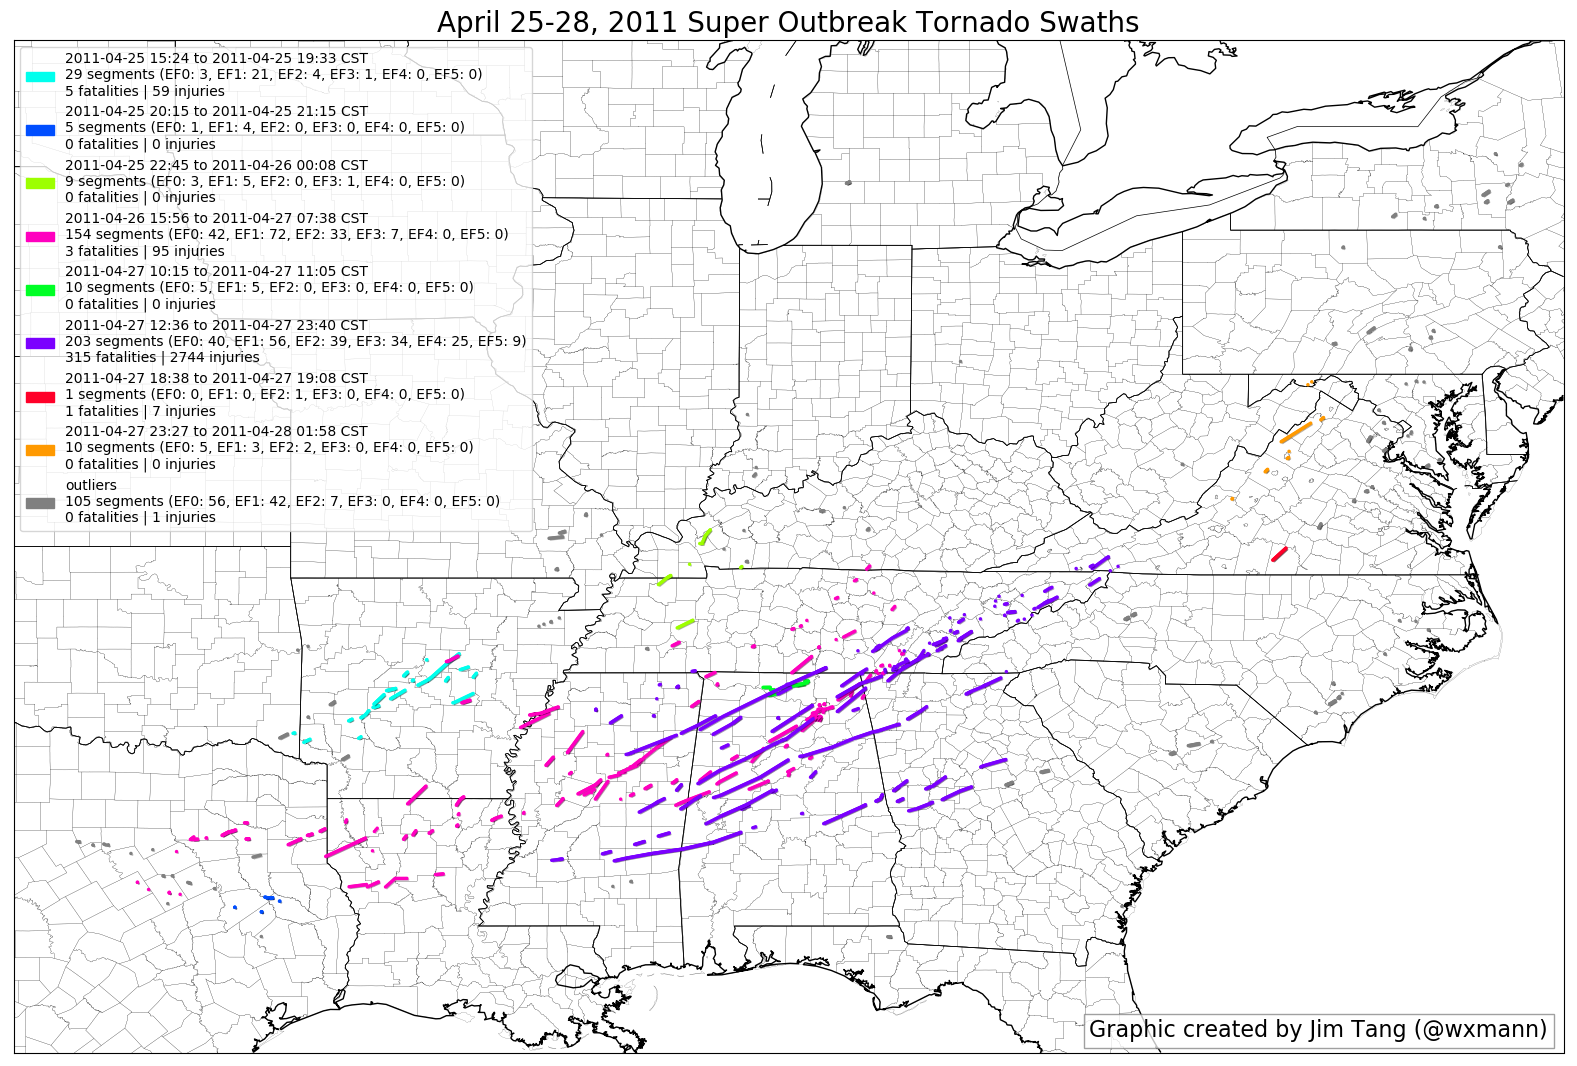

In [5]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
%matplotlib inline

fig = plt.figure(figsize=(20, 20), dpi=100)
        
llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat = -99, -74.5, 29, 45
m = Basemap(projection='cyl', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
            resolution='i',area_thresh=1000)

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawcounties()

# function courtesy http://qingkaikong.blogspot.com/2016/08/clustering-with-dbscan.html
def get_cmap(N):
    '''
    Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.
    '''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cm.ScalarMappable(norm=color_norm, cmap='gist_rainbow_r') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

# colors = cm.gist_rainbow_r(np.linspace(0, 1, len(torclusters)))
colors = get_cmap(len(torclusters))
shadow = path_effects.withSimplePatchShadow(offset=(1, -1))

legend_handles = []

def cluster_label(clust, color, outlier=False):
    if not outlier:
        time_part = '{} to {} CST'.format(clust.begin_time.strftime('%Y-%m-%d %H:%M'), 
                                          clust.end_time.strftime('%Y-%m-%d %H:%M'))
    else:
        time_part = 'outliers'
        
    clust_events = clust.events
    clust_events = clust_events[clust_events.event_type == 'Tornado']
    efs = stormevents.tors.ef(clust_events)
#     longevities = stormevents.tors.longevity(clust_events)
    
    ef_parts= ['EF{}: {}'.format(f, len(efs[efs == f])) for f in range(0, 6)]
    segments_part = '{} segments ({})'.format(len(clust_events), ', '.join(ef_parts))
    
    fats = clust_events.deaths_direct.sum()
    injs = clust_events.injuries_direct.sum()
    casualty_part = '{} fatalities | {} injuries'.format(fats, injs)
    
#     total_tornado_time = longevities.sum().seconds
#     hours = total_tornado_time // 3600
#     minutes = (total_tornado_time % 3600) // 60
    
#     if hours == 0:
#         longevity_part = 'Tornado time: {} min'.format(minutes)
#     else:
#         longevity_part = 'Tornado time: {} hr {} min'.format(hours, minutes)
    
    return '\n'.join([time_part, segments_part, casualty_part])
    
for clust in sorted(torclusters, key=lambda cl: cl.begin_time):
    color = colors(clust.index)
    clust.plot(m, markersize=1.5, color=color, path_effects=[shadow])
    legend_handles.append(mpatches.Patch(color=color, label=cluster_label(clust, color)))
    
noise.plot(m, markersize=1.5, color='gray', path_effects=[shadow])
legend_handles.append(mpatches.Patch(color='gray', 
                                     label=cluster_label(noise, 'gray', outlier=True)))

plt.legend(handles=legend_handles, loc=2)
plt.title('April 25-28, 2011 Super Outbreak Tornado Swaths', fontsize=20)

ax = fig.axes[0]
plt.text(0.99, 0.01, 'Graphic created by Jim Tang (@wxmann)', transform=ax.transAxes, fontsize=16,
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(alpha=0.75, facecolor='white', edgecolor='gray'))
plt.show()